In [3]:
from skimage import io, filters, morphology
import plotly.graph_objects as go
import pyvista
import numpy as np

In [8]:
points = np.random.random((1000, 3))
cloud = pyvista.wrap(points)
cloud  

PolyData (0x7fa7d1e3e050)
  N Cells:	1000
  N Points:	1000
  X Bounds:	2.985e-03, 9.996e-01
  Y Bounds:	1.264e-04, 9.995e-01
  Z Bounds:	1.518e-04, 9.976e-01
  N Arrays:	0

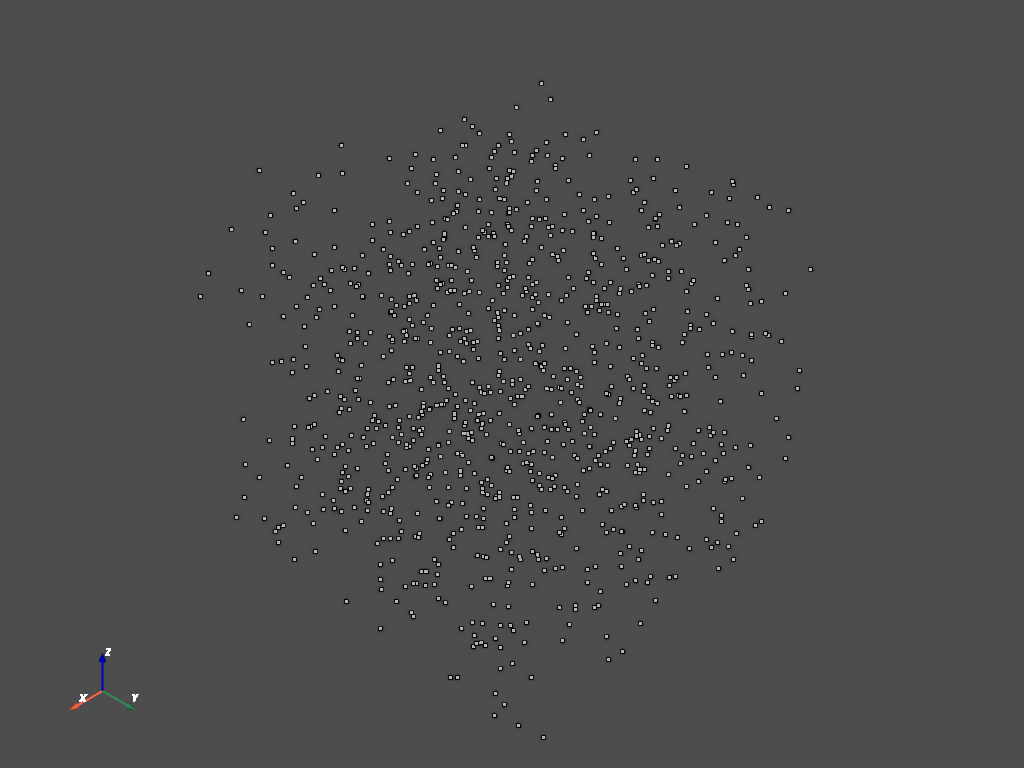

[(2.4288969847728072, 2.4274315969691083, 2.4265166274065852),
 (0.5012748020967166, 0.49980941429301723, 0.4988944447304942),
 (0.0, 0.0, 1.0)]

In [9]:
cloud.plot(eye_dome_lighting=True)

In [20]:
img = io.imread('stack1.tiff')#[:,100:200,150:250]

b_stack = zeros_like(img)

print('process...')
for i in range(img.shape[0]):
    frame = img[i]
    frame = filters.gaussian(frame)
    frame = frame / frame.max()
    bimg = zeros_like(frame)
    bimg[frame > 0.2] = 1
    bimg = morphology.area_opening(bimg, 100)
    bimg = morphology.area_closing(bimg, 100)

    dx = gradient(bimg, axis=0)
    dy = gradient(bimg, axis=1)
    bimg = dx**2 + dy**2
    bimg[bimg != 0] = 1

    b_stack[i] = bimg

# ax = axes(projection='3d')

print('do vectors')
X, Y, Z, V = [], [], [], []
for (z, y, x), v in ndenumerate(b_stack):
    if v == 1:
        X.append(x)
        Y.append(y)
        Z.append(z)
        V.append(v)

X = array(X)
Y = array(Y)
Z = array(Z)
V = array(V)

print(X.shape)
print('showing')

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=V.flatten(),
    isomin=0,
    isomax=1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=1, # needs to be a large number for good volume rendering
    ))
fig.show()

process...
do vectors
(89675,)
showing


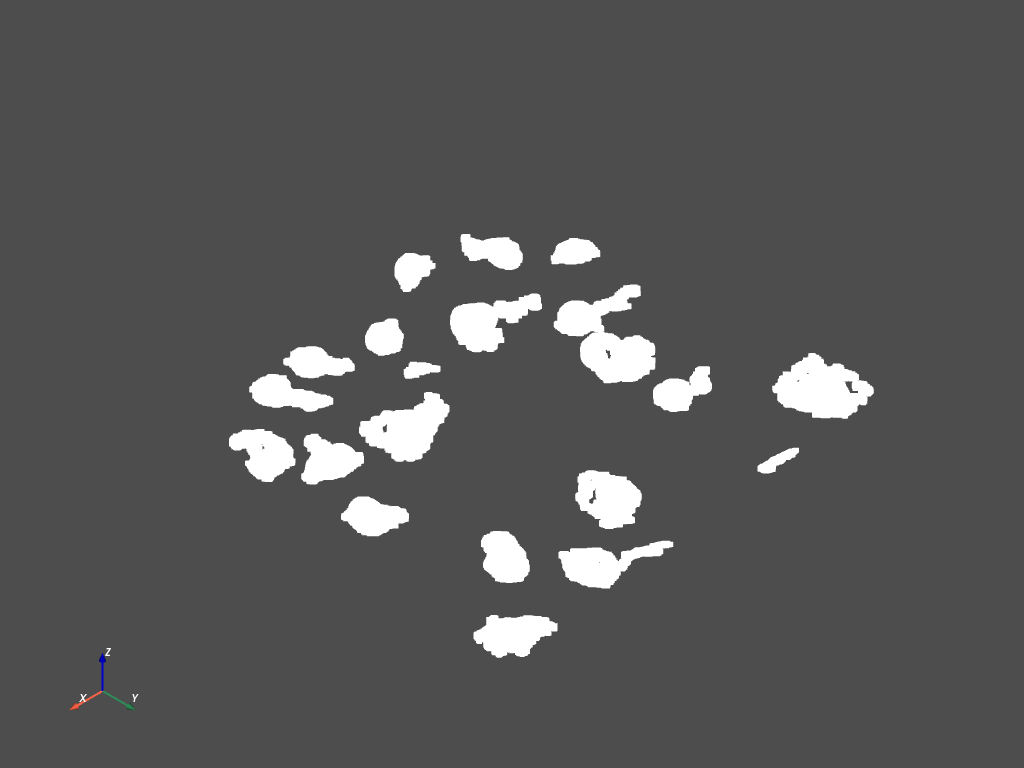

[(1058.6571115083893, 1060.6571115083893, 812.6571115083894),
 (255.5, 257.5, 9.5),
 (0.0, 0.0, 1.0)]

In [21]:
points = np.vstack((X.T, Y.T, Z.T)).T
cloud = pyvista.wrap(points)
cloud.plot()

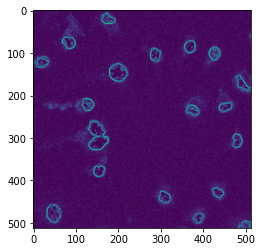

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data, io, morphology

# coins = data.coins()
coins = io.imread('stack1.tiff')[10]#[:,100:200,150:250]


# Make segmentation using edge-detection and watershed.
edges = sobel(coins)
plt.imshow(edges)

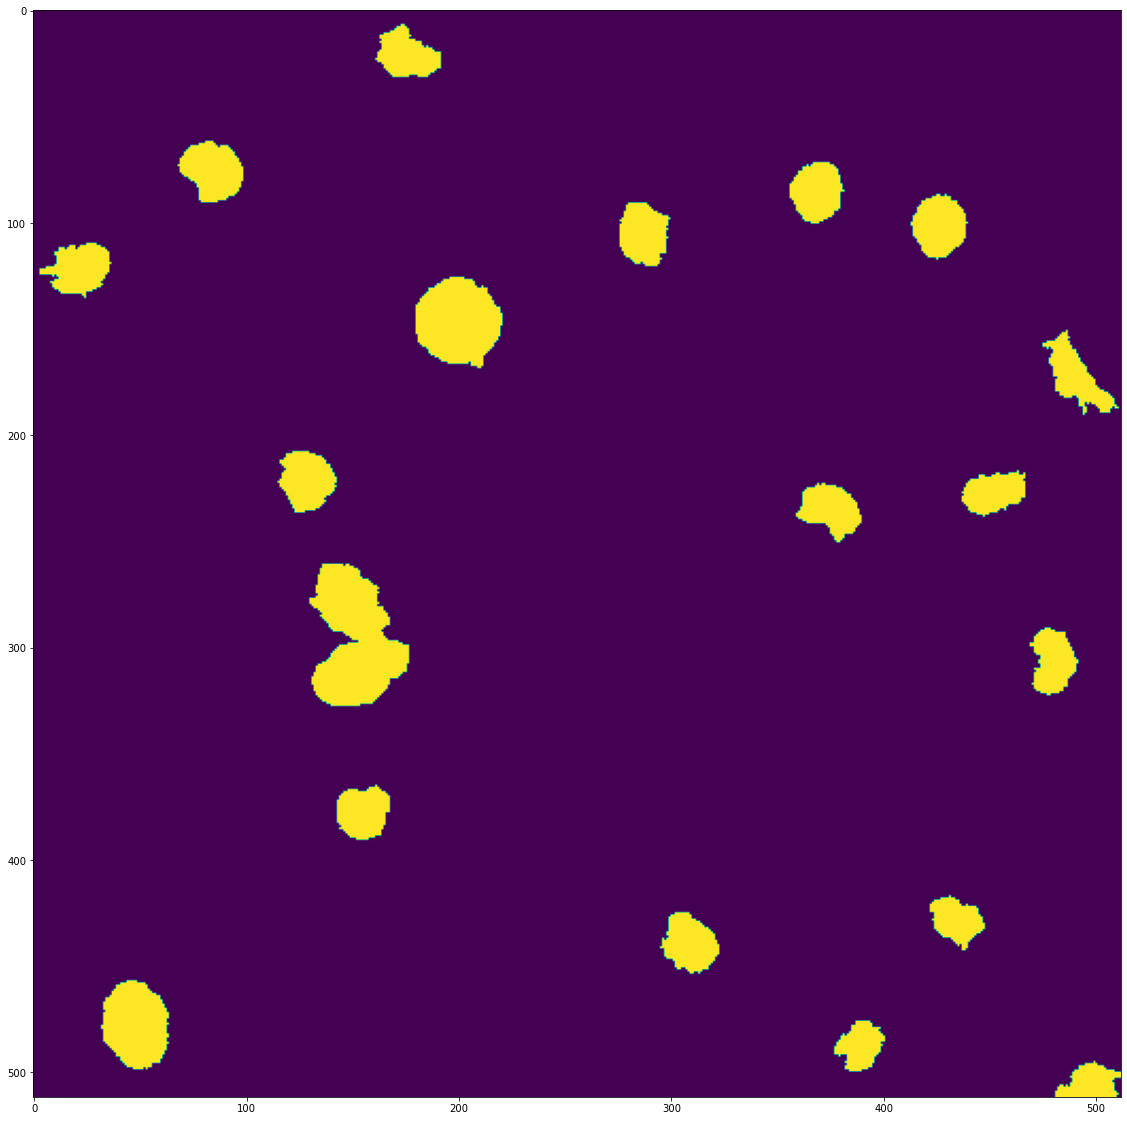

In [26]:
# Identify some background and foreground pixels from the intensity values.

def do_watershed(img):
    edges = sobel(img)
    # markers = np.zeros([img.shape[0], img.shape[1], 2])
    markers = np.zeros_like(img)
    foreground, background = 1, 2
    markers[coins < 40.0] = background
    markers[coins > 150.0] = foreground

    ws = watershed(edges, markers)
    seg = ws == foreground
    return seg

def nonmax_suppression(mask, size = 100):
    mask = morphology.area_opening(mask, size)
    return mask


fig = plt.figure(figsize=(20,20))
mask = do_watershed(coins)
mask = nonmax_suppression(mask)
plt.imshow(mask)

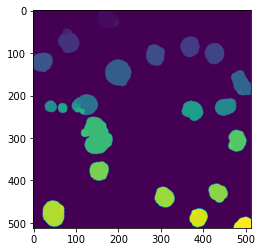

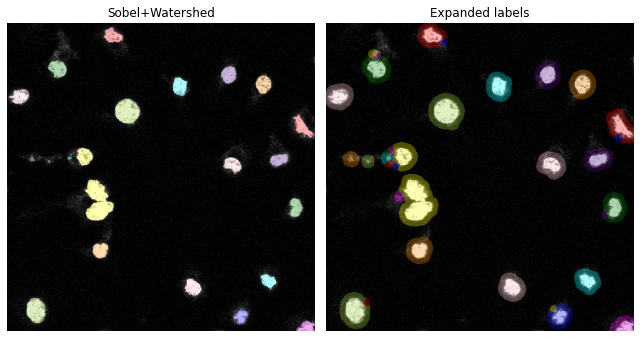

In [16]:
expanded = expand_labels(seg1, distance=10)
plt.imshow(expanded)
plt.show()
# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

color2 = label2rgb(expanded, image=coins, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Expanded labels')

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()